## Analysis Outline: Putative Cell Types × Behavioral Events

### Goal
Investigate whether **pyramidal neurons vs. interneurons** show different levels of significance across behavioral events.

### Dataset Structure
- **units_df**: grouped by `Recording` and `Unit number`  
  - `sig events`: list of events where the unit was significant  
  - `not sig events`: list of events where the unit was not significant  
  - `putative type`: classification of the unit (pyramidal or interneuron)  

- **sig_units**: subset of `units_df` containing only units with at least one `sig event`.

### Planned Analyses
1. **Overall proportions (baseline check)**  
   - % of pyramidal vs. interneuron units  
   - % of significant pyramidal vs. significant interneuron units  
   - % of sig units relative to all units  

2. **Event-level comparisons**  
   - For each event in:  
     `['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']`  
     - Compute % of sig pyramidal units  
     - Compute % of sig interneuron units  
     - Compare distributions across events  

3. **Statistical testing (next steps)**  
   - Chi-square or Fisher’s Exact test to determine if **the proportion of significant units differs between events**.  
   - Possible logistic regression with predictors = event type, putative type.  

### Current Results (across all recordings)
- Interneurons / # sig units = **5.6%**  
- Interneurons / # units = **5.7%**  
- Pyramidal / # units = **94%**  
- Sig pyramidal / # sig units = **94%**  
- Sig pyramidal / # units = **23.1%**  
- Sig interneurons / # units = **1.3%**

---
✅ **Next Step**: Break down the percentages by event type to see if certain behaviors drive higher significance in pyramidal vs. interneurons.


In [25]:
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.spike_recording as sr
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.normalization as norm
import spike.spike_analysis.single_cell as single_cell
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.zscoring as zscoring
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import behavior.boris_extraction as boris
import matplotlib.pyplot as plt
import pickle
import re
import ast
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

In [26]:
pd.set_option('display.max_colwidth', 0)  # 0 means unlimited in newer pandas versions

# Show all rows
pd.set_option("display.max_rows", None)

# Show all columns
pd.set_option("display.max_columns", None)

# Don’t truncate column contents
pd.set_option("display.max_colwidth", None)

# Expand the display to the full width of the screen
pd.set_option("display.width", 0)


In [27]:
EVENTS = [
    'alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose',
    'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline',
    'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline',
    'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win'
]

### Dataframe of units, putative types, sig, events 

In [28]:
df_path = r'C:\Users\thoma\Code\ResearchCode\diff_fam_social_memory_ephys\other_peoples_sutff\Thomas\reward_comp\outputs\final_sig_putative.csv'

### Preparing df for analysis

In [ ]:
# 1) Read
units_df = pd.read_csv(df_path)

# 2) Convert stringified lists -> real lists
for col in ['sig events', 'not sig events']:
    units_df[col] = units_df[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str)
        else ([] if pd.isna(x) else x)
    )

# 3) Normalize labels
units_df['putative type'] = units_df['putative type'].astype(str).str.strip().str.lower()

# 4) (Re)build derived frames AFTER conversion
units = units_df.copy()
sig_units = units_df[units_df['sig events'].apply(lambda L: len(L) > 0)].copy()

# 5) Helpers (unchanged)
def event_tested(row, event):
    return (event in row['sig events']) or (event in row['not sig events'])

def event_significant(row, event):
    return event in row['sig events']


In [37]:
units_df.head()

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,104,"[lose, low_comp_lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,11,[],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,122,[],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,125,[],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,126,[],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal


##### Example usage of event_tested and event_significant

In [36]:
# Pick a single row (unit) and an event name
row = units_df.iloc[0]
print("Row sig events:", row['sig events'])
print("Row not sig events:", row['not sig events'])

# Example event
ev = "win"

print("Tested?", event_tested(row, ev))
print("Significant?", event_significant(row, ev))


Row sig events: ['lose', 'low_comp_lose']
Row not sig events: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'low_comp', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']
Tested? True
Significant? False


In [43]:
# number of high_comp_lose in sig_events in units_df
subset = units_df[units_df['sig events'].apply(lambda x: "high_comp_lose" in x)]
print(len(subset))
subset.head(20)

66


,Recording,Unit number,sig events,not sig events,putative type
28,20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec,52,"[alone_rewarded, high_comp, high_comp_lose, high_comp_win, low_comp, low_comp_win, win]","[alone_rewarded_baseline, high_comp_lose_baseline, high_comp_win_baseline, lose, low_comp_lose, low_comp_lose_baseline, low_comp_win_baseline, overall_pretone]",pyramidal
31,20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec,68,"[alone_rewarded, high_comp, high_comp_lose, high_comp_win, lose, low_comp, low_comp_win, win]","[alone_rewarded_baseline, high_comp_lose_baseline, high_comp_win_baseline, low_comp_lose, low_comp_lose_baseline, low_comp_win_baseline, overall_pretone]",pyramidal
33,20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged.rec,34,"[high_comp, high_comp_lose, lose]","[alone_rewarded, alone_rewarded_baseline, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
42,20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged.rec,83,"[high_comp, high_comp_lose, lose, low_comp, low_comp_lose]","[alone_rewarded, alone_rewarded_baseline, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
47,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,1,"[high_comp_lose, lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
49,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,14,"[high_comp_lose, lose, low_comp_lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
52,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,2,[high_comp_lose],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
54,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,211,[high_comp_lose],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",interneuron
56,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,240,"[high_comp_lose, lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
58,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,283,"[high_comp_lose, lose, low_comp, low_comp_lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal


## Methods: Event-Level Significance by Putative Cell Type

### Purpose
Quantify and compare, **for each behavioral event**, the proportion of units that are significant among those **actually tested** for that event, split by **pyramidal** vs **interneuron**, and assess whether the proportions differ (Fisher’s exact test with FDR correction across events).

---

### Key Definitions
- **Tested (unit, event)**: An event is considered *tested* for a unit if it appears in **either** that unit’s `sig events` **or** `not sig events`.  
  - `sig events`: events where the unit was significant  
  - `not sig events`: events where the unit was evaluated but not significant  
  - If an event is in neither list, the unit was **not** tested for that event and is excluded from the denominator.

---

### Per-Event Summary Procedure (`summarize_event`)
1. **Filter to tested units**  
   For a given `event`, keep only rows (units) where `event ∈ (sig events ∪ not sig events)`.  
   This ensures the denominator contains only units that were actually evaluated for that event.

2. **Split by putative type**  
   From the *tested* subset, create:
   - `pyr`: tested pyramidal units  
   - `itn`: tested interneuron units

3. **Count tested vs significant**  
   For each type, compute:
   - `n_tested_*` = number of tested units  
   - `n_sig_*` = number of those that have the event in `sig events`  
   - `pct_sig_*` = `n_sig_* / n_tested_* × 100`

4. **Build 2×2 contingency table**  
   For the event, construct:


In [30]:
def summarize_event(units_df, event):
    """
    Build per-event 2x2 counts for [sig vs not-sig] x [pyramidal vs interneuron],
    compute percentages and Fisher's exact test.
    """
    # Filter units that were actually tested for this event
    tested = units_df[units_df.apply(lambda r: event_tested(r, event), axis=1)].copy()
    if tested.empty:
        print("tested empty")
        return {
            'event': event,
            'n_tested_pyramidal': 0, 'n_sig_pyramidal': 0, 'pct_sig_pyramidal': np.nan,
            'n_tested_interneuron': 0, 'n_sig_interneuron': 0, 'pct_sig_interneuron': np.nan,
            'odds_ratio_Pyr_vs_Int': np.nan, 'p_value': np.nan
        }

    # Split by putative type
    pyr = tested[tested['putative type'].str.contains('pyramidal', case=False, na=False)]
    itn = tested[tested['putative type'].str.contains('interneuron', case=False, na=False)]

    def counts(df):
        n_tested = len(df)
        n_sig = df.apply(lambda r: event_significant(r, event), axis=1).sum()
        return n_tested, int(n_sig), int(n_tested - n_sig)

    n_tested_pyr, n_sig_pyr, n_nsig_pyr = counts(pyr)
    n_tested_int, n_sig_int, n_nsig_int = counts(itn)

    # Build 2x2 table for Fisher: rows=type, cols=outcome
    # [[sig_pyr, notsig_pyr],
    #  [sig_int, notsig_int]]
    table = np.array([[n_sig_pyr, n_nsig_pyr],
                      [n_sig_int, n_nsig_int]], dtype=int)

    # Guard for degenerate tables (all zeros)
    if table.sum() == 0 or (n_tested_pyr == 0 and n_tested_int == 0):
        or_val, p_val = np.nan, np.nan
    else:
        # Use Fisher's exact (safe with small counts)
        or_val, p_val = fisher_exact(table, alternative='two-sided')

    out = {
        'event': event,
        'n_tested_pyramidal': n_tested_pyr,
        'n_sig_pyramidal': n_sig_pyr,
        'pct_sig_pyramidal': (n_sig_pyr / n_tested_pyr * 100.0) if n_tested_pyr > 0 else np.nan,
        'n_tested_interneuron': n_tested_int,
        'n_sig_interneuron': n_sig_int,
        'pct_sig_interneuron': (n_sig_int / n_tested_int * 100.0) if n_tested_int > 0 else np.nan,
        'odds_ratio_Pyr_vs_Int': or_val,
        'p_value': p_val,
    }
    return out

# Run for all events
summary_rows = [summarize_event(units, ev) for ev in EVENTS]
event_summary = pd.DataFrame(summary_rows)

# Diagnostic: see which events actually had any tested units
event_summary['n_tested_total'] = (
    event_summary['n_tested_pyramidal'].fillna(0).astype(int) +
    event_summary['n_tested_interneuron'].fillna(0).astype(int)
)

# FDR only if we have at least one finite p-value
mask = event_summary['p_value'].notna()

if mask.sum() > 0:
    rej, p_fdr, _, _ = multipletests(event_summary.loc[mask, 'p_value'], method='fdr_bh')
    event_summary.loc[mask, 'p_fdr'] = p_fdr
    event_summary.loc[mask, 'reject_FDR_0.05'] = rej
else:
    # No valid p-values: fill sensible defaults
    event_summary['p_fdr'] = np.nan
    event_summary['reject_FDR_0.05'] = False

# Optional: filter out events with no tests (helps readability)
event_summary = event_summary[event_summary['n_tested_total'] > 0].reset_index(drop=True)

event_summary.head(15)


,event,n_tested_pyramidal,n_sig_pyramidal,pct_sig_pyramidal,n_tested_interneuron,n_sig_interneuron,pct_sig_interneuron,odds_ratio_Pyr_vs_Int,p_value,n_tested_total,p_fdr,reject_FDR_0.05
0,alone_rewarded,338,18,5.325444,19,2,10.526316,0.478125,0.288532,357,1.0,False
1,alone_rewarded_baseline,209,4,1.913876,15,0,0.000000,inf,1.000000,224,1.0,False
2,high_comp,612,28,4.575163,37,2,5.405405,0.839041,0.686175,649,1.0,False
3,high_comp_lose,568,62,10.915493,37,4,10.810811,1.010870,1.000000,605,1.0,False
4,high_comp_lose_baseline,227,4,1.762115,17,0,0.000000,inf,1.000000,244,1.0,False
5,high_comp_win,512,29,5.664062,27,2,7.407407,0.750518,0.663304,539,1.0,False
6,high_comp_win_baseline,209,4,1.913876,15,0,0.000000,inf,1.000000,224,1.0,False
7,lose,583,56,9.605489,37,3,8.108108,1.204301,1.000000,620,1.0,False
8,low_comp,612,39,6.372549,37,2,5.405405,1.191099,1.000000,649,1.0,False
9,low_comp_lose,470,41,8.723404,30,3,10.000000,0.860140,0.739775,500,1.0,False


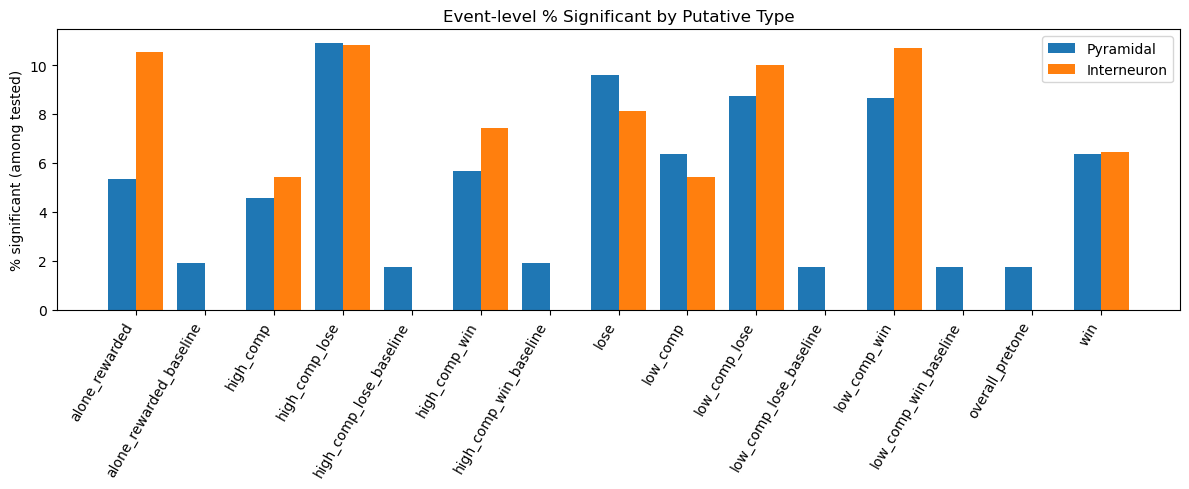

In [31]:
plot_df = event_summary.copy()
x = np.arange(len(plot_df['event']))

plt.figure(figsize=(12,5))
plt.bar(x - 0.2, plot_df['pct_sig_pyramidal'], width=0.4, label='Pyramidal')
plt.bar(x + 0.2, plot_df['pct_sig_interneuron'], width=0.4, label='Interneuron')
plt.xticks(x, plot_df['event'], rotation=60, ha='right')
plt.ylabel('% significant (among tested)')
plt.title('Event-level % Significant by Putative Type')
plt.legend()
plt.tight_layout()
plt.show()


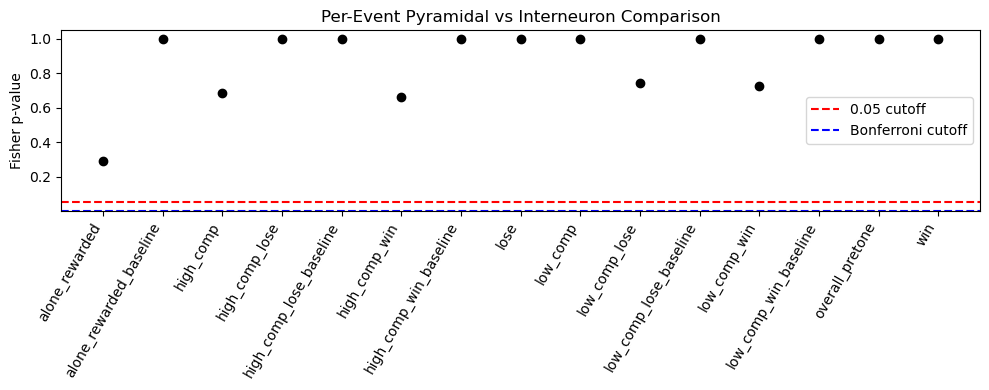

In [45]:
plt.figure(figsize=(10,4))
plt.scatter(plot_df['event'], plot_df['p_value'], color='black')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 cutoff')
plt.axhline(0.05/len(plot_df), color='blue', linestyle='--', label='Bonferroni cutoff')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Fisher p-value')
plt.title('Per-Event Pyramidal vs Interneuron Comparison')
plt.legend()
plt.tight_layout()
plt.show()


### Next: 
1. Test if there's a difference in increase and decrease between events
2.  check other events, check baseline is what we think it is
3. hand calculate pvalues make sure it's correct

In [32]:
# Build long-form table: one row per (unit, event) that was tested
rows = []
for _, r in units.iterrows():
    pt = r['putative type']
    rec = r['Recording']
    unit = r['Unit number']
    sig_set = set(r['sig events'] or [])
    nsig_set = set(r['not sig events'] or [])
    tested_events = sig_set | nsig_set
    for ev in tested_events:
        rows.append({
            'Recording': rec,
            'Unit': unit,
            'putative_type': pt,
            'event': ev,
            'sig': int(ev in sig_set)
        })

long_df = pd.DataFrame(rows)

# statsmodels logistic regression with cluster-robust SE by Recording (or by Unit)
import statsmodels.formula.api as smf

# Baseline model: main effects only
m1 = smf.glm('sig ~ C(event) + C(putative_type)',
             data=long_df, family=__import__('statsmodels.api').api.families.Binomial()).fit(cov_type='cluster', cov_kwds={'groups': long_df['Recording']})
print(m1.summary())

# Interaction model: allow type effect to vary by event
m2 = smf.glm('sig ~ C(event) * C(putative_type)',
             data=long_df, family=__import__('statsmodels.api').api.families.Binomial()).fit(cov_type='cluster', cov_kwds={'groups': long_df['Recording']})
print(m2.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    sig   No. Observations:                 6691
Model:                            GLM   Df Residuals:                     6674
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1491.1
Date:                Fri, 29 Aug 2025   Deviance:                       2982.2
Time:                        10:26:37   Pearson chi2:                 6.69e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01672
Covariance Type:              cluster                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In